# Installing package for ALS

In [ ]:
!pip install implicit

# Loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np
import scipy.sparse as sparse
import pandas as pd
master_path = "/content/drive/MyDrive/Applied Machine Learning Project/h-and-m-personalized-fashion-recommendations"
pp_path = "/content/drive/MyDrive/Applied Machine Learning Project/preprocessed_data"
csv_users = master_path+"/customers.csv"
csv_items = master_path+"/articles.csv"
csv_train = master_path+"/transactions_train.csv"

/usr/local/lib/python3.7/dist-packages/implicit/gpu/__init__.py:14: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: no CUDA-capable device is detected (/project/./implicit/gpu/utils.h:71)'
  f"CUDA extension is built, but disabling GPU support because of '{e}'",


In [ ]:
users_df = pd.read_csv(csv_users)
articles_df = pd.read_csv(csv_items, dtype={'article_id': str})
train_df = pd.read_csv(csv_train,parse_dates=['t_dat'], dtype={'article_id': str})
# train_df number of entries : 31788324


# Taking last month of data for training

In [ ]:

# 1 month :1190911 (3%)

# Creating indexes for all unique customers and articles

In [ ]:
customer_list_unique = users_df['customer_id'].unique().tolist()
article_list_unique = articles_df['article_id'].unique().tolist()
idx_to_user = dict(list(enumerate(customer_list_unique)))
idx_to_article = dict(list(enumerate(article_list_unique)))
user_to_idx = {u: uidx for uidx, u in idx_to_user.items()}
article_to_idx = {i: iidx for iidx, i in idx_to_article.items()}

# Mapping indexes to training_data

In [ ]:

# train_1_month["uidx"] = train_1_month["customer_id"].map(user_to_idx)
# train_1_month["iidx"] = train_1_month["article_id"].map(article_to_idx)
# full data
train_df["uidx"] = train_df["customer_id"].map(user_to_idx)
train_df["iidx"] = train_df["article_id"].map(article_to_idx)

In [ ]:
train_1_month = train_df[train_df["t_dat"]>"2020-08-21"]

In [ ]:
# delete to save memory
# del users_df

# Group index of purchased items by User

In [ ]:
train_grouped = train_1_month.groupby(["uidx","customer_id"])['iidx'].apply(lambda items: list(set(items)))
# train_grouped = train_grouped[train_grouped.str.len() >= 3]
# train_for_rec.to_csv(str(pp_path+"/train_for_rec.csv"))

# Get count of purchased items by user and item 

In [ ]:
train_for_rec= train_1_month.groupby(['uidx',"customer_id", "iidx",'article_id']).size().reset_index(name='total_item')

In [ ]:
# for saving
# train_for_rec.to_csv(str(pp_path+"/train_for_rec.csv"))
# train_for_rec = pd.read_csv(str(pp_path+"/train_for_rec.csv"), 
#                             dtype={'article_id': str})
# train_for_rec.drop(columns="Unnamed: 0", inplace=True)
# train_for_rec = train_for_rec[train_for_rec["total_item"]>=3]
# train_for_rec["iidx"].nunique()

# Create Sparse User-Item CSR Matrix

In [ ]:
len(customer_list_unique)

1371980

In [ ]:
def get_csr_ui_matrix(df):
  user_row = df["uidx"].values
  item_col = df["iidx"].values
  csr_ui_matrix = sparse.csr_matrix((df["total_item"].astype(float), 
                                     (user_row, item_col)),
                                    shape=(len(customer_list_unique), len(article_list_unique)))
  return csr_ui_matrix

def get_coo_ui_matrix(df):
  user_row = df["uidx"].values
  item_col = df["iidx"].values
  data = np.ones(df.shape[0])
  csr_ui_matrix = sparse.coo_matrix((data, 
                                     (user_row, item_col)),
                                    shape=(len(customer_list_unique), len(article_list_unique)))
  return csr_ui_matrix
coo_ui_matrix = get_coo_ui_matrix(train_for_rec)

# Train ALS

In [ ]:
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

# alpha = 15
data = (coo_ui_matrix).astype("double")
model = AlternatingLeastSquares(factors=360, # replace with 360 
                                regularization=0.1,
                                # dtype=np.float32,
                                iterations=5) # replace with 5
model.fit(data)


  0%|          | 0/5 [00:00<?, ?it/s]

# Get Recommendations

In [86]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy import spatial
def get_recommendations(user,coo, n=10):
  idx = user_to_idx[user]
  n_temp = n
  while True:
    recs_idx, scores = model.recommend(idx, coo.tocsr()[idx],
                                     N=n_temp,
                                     filter_already_liked_items=True)
    articles = []
    scores_l = []
    for i,v in enumerate(recs_idx):
      if v in idx_to_article.keys():
        articles.append(idx_to_article[v])
        scores_l.append(scores[i])
    if len(articles)<n:
      n_temp+=1
    else:
      return articles, scores_l
# https://stackoverflow.com/questions/46975929/how-can-i-calculate-the-jaccard-similarity-of-two-lists-containing-strings-in-py  
def Jaccar_score(lista_1, lista_2):   
    inter = len(list(set(lista_1) & set(lista_2)))
    union = len(list(set(lista_1) | set(lista_2)))
    return inter/union



# Random sample of users for evaluation


In [ ]:
import random as r
train_for_eval = train_for_rec#[train_for_rec["total_item"]>=3]
test_users = np.random.choice(train_for_eval["customer_id"].unique(), 1000, replace=False)
test_users_grouped = train_for_eval[train_for_eval["customer_id"].isin(test_users)].groupby("customer_id").sum("total_item").reset_index()


In [ ]:
train_users_grouped = train_grouped.reset_index()

In [ ]:
articles_df = pd.read_csv(csv_items, dtype={'article_id': str})

In [ ]:
articles_df.drop(columns=["detail_desc"],inplace=True)
cat_names= articles_df.select_dtypes(include=['category']).columns
cont_names = articles_df.select_dtypes(include=['int64']).columns
obj_names = articles_df.select_dtypes(include=['object']).columns

for i in cat_names: 
    articles_df[i+'_cat']=articles_df[i].astype('category')
for i in obj_names: 
    if i!= "article_id":
      articles_df.drop(columns=[i], inplace = True)

In [ ]:
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances
from sklearn.metrics import jaccard_score
from scipy.stats import pearsonr
cosine_list = []
euclid_list =[]
jaccard_list = []
pearson_list =[]
og_list = []
rec_list =[]
scores_list =[]
for t in range(1000):
  u = test_users_grouped["customer_id"][t]
  y_idx = train_users_grouped[train_users_grouped["customer_id"].isin([u])]["iidx"].values[0]
  p = len(y_idx)
  recs_ids, scores = get_recommendations(u , coo_ui_matrix,p)
  scores_list.append(scores)
  y_ids = []
  for i in y_idx:
    y_ids.append(idx_to_article[i])
  rec_list.append(recs_ids)
  og_list.append(y_ids)
  rec_hat = articles_df[articles_df["article_id"].isin(recs_ids)].drop(columns=["article_id"])
  y = articles_df[articles_df["article_id"].isin(y_ids)].drop(columns=["article_id"])
  pearsons = []
  cosines = []
  jaccards = []
  euclids = []
  if rec_hat.shape[0]!=y.shape[0]:
    print("bad")
    break
  for i in range(p):
    ri, yi = rec_hat.iloc[i],y.iloc[i]
    pearsons.append(pearsonr(ri,yi )[0])
    cosines.append(cosine_similarity(ri.to_numpy().reshape(1,-1),
                                     yi.to_numpy().reshape(1,-1)))
    jaccards.append(Jaccar_score(list(ri),list(yi)))
    euclids.append(euclidean_distances(ri.to_numpy().reshape(1,-1),
                                       yi.to_numpy().reshape(1,-1)))

  cosine_list.append(np.mean(cosines))
  euclid_list.append(np.mean(euclids))
  jaccard_list.append(np.mean(jaccards))
  pearson_list.append(np.mean(pearsons))

In [ ]:
print("cosine similarity:", np.asarray(cosine_list).mean())
print("euclid:", np.asarray(euclid_list).mean())
print("jaccard:", np.asarray(jaccard_list).mean())
print("pearson R:", np.asarray(pearson_list).mean())

cosine similarity: 0.9963642429286119
euclid: 72093.78113422504
jaccard: 0.2940599303849019
pearson R: 0.9956111003133544


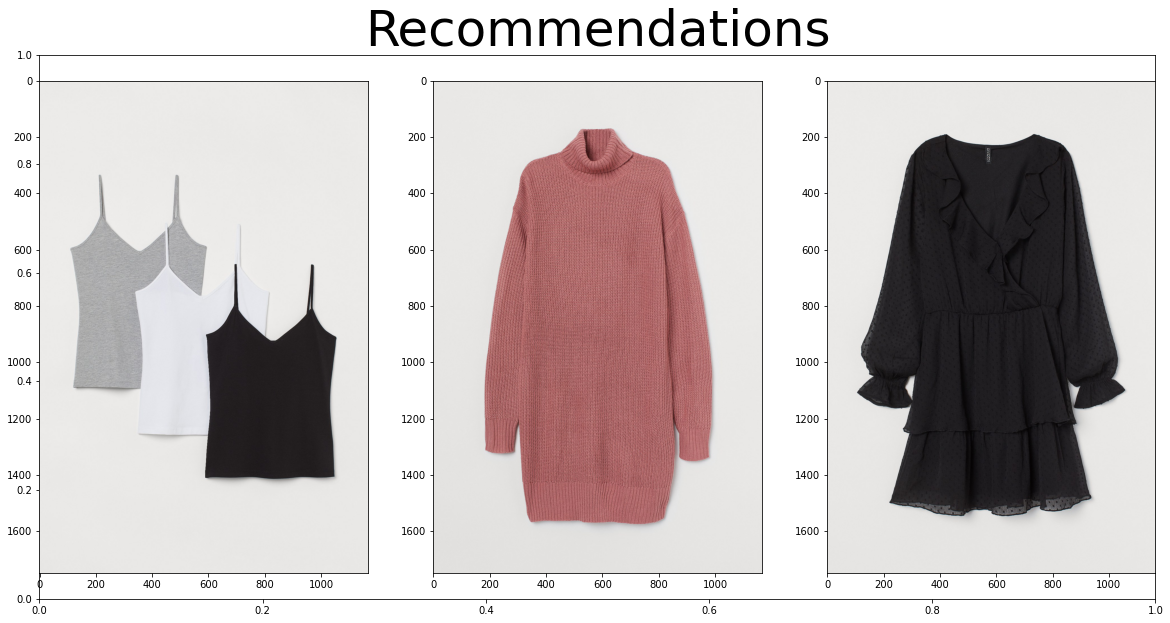

In [98]:
def show_articles(article_ids, title):
  fig = plt.figure(figsize=(20, 10))
  plt.title(title,fontsize=50)
  for i,v in enumerate(article_ids):
    folder = v[:3]
    img_path = master_path+"/images/{folder}/{image}.jpg".format(folder=folder,image=v)
    image = plt.imread(img_path)
    fig.add_subplot(1, len(article_ids), i+1)
    plt.imshow(image)
show_articles(rec_list[1], "Recommendations")

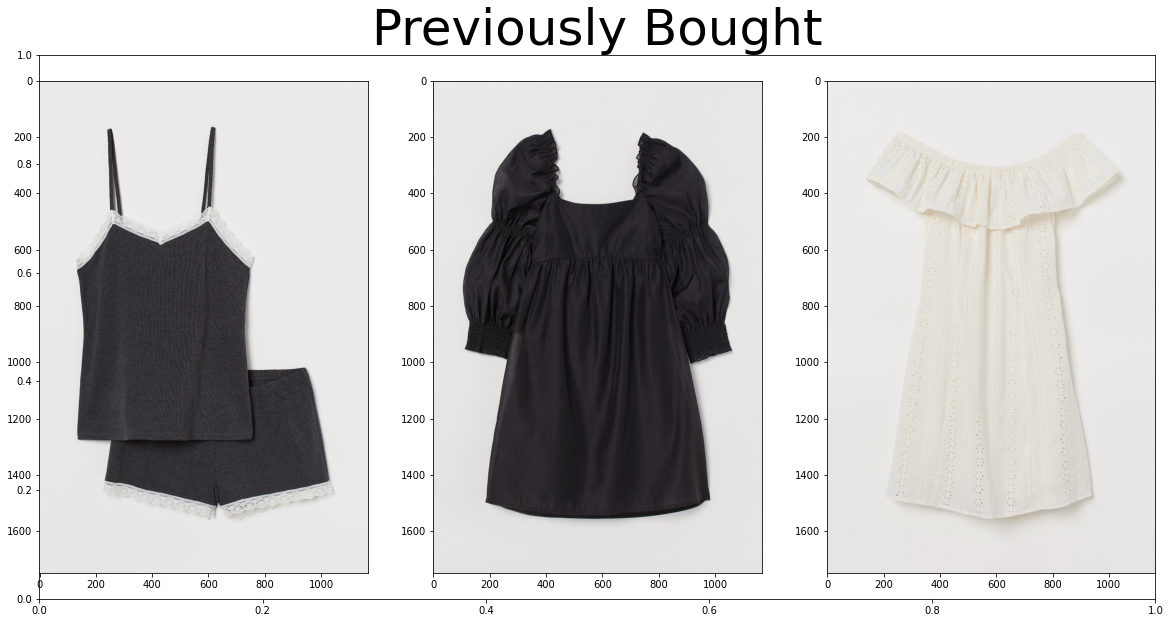

In [99]:
show_articles(og_list[1], "Previously Bought")